In [1]:
# ====================================================================================
# Numerical Computation of VECTORIAL DIFFRACTION based on the Debye-Wolf Integral
# ====================================================================================
# Script written by Martin Regehly
# Please reference the publication "Split-Aperture Xolography – Linear volumetric
# photoactivation with short axial dimension and low out of focus excitation" for use

# import Python libraries
import numpy as np
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [2]:
# set definitions of the system
# =================================================================
l=405E-9 # wavelength in m
#calculate angular wavenumber
k=2*np.pi/l

# refractive index of the homogeneous focusing media 
#n=1.0 #(air)
n=1.44+16823.71/(l*1.0E9)**2  #refractive index of monomer PETA at desired wavelength 

#define beam polarisation by jones vector
E=[1,0] # linear x polarised 
fx=0;fy=0

#focusing lens definitions 
#first option using the numerical aperture of the lens
#NA=0.95 
#alpha=np.arcsin(NA/n)
# second option by defining the focusing angle of the lens
alpha=np.arcsin(0.95)
#alpha=np.deg2rad(27.0)
# focal length in m - it is only a constant in the Debye-Wolf integral
# we choose an arbitrary value as we are not interested in absolute values of the electric field in the focal zone
f=1.6*1E-3
 
# generate a set of desired cartesian coordinates at which the PSF in the focus zone is to be calculated 
# this script is for calculation of the focal plane PSF = lateral(XY Z=0,2D) slice
#generate image plane cartesian coordinates 
window=1000E-9 # in m, here we calculate from x=-1000nm to x=1000nm, y=-1000nm to y=1000nm
startx=-window  
stopx=window
starty=-window
stopy=window
spacex=200     # number of points x (significant influence on computation time)
spacey=200     # number of points y (significant influence on computation time)
xvals=np.linspace(startx,stopx,spacex)
yvals=np.linspace(starty,stopy,spacey)

# set up an array to store the 3 component electric field vector in the focal zone
Efield=np.empty((spacex,spacey,3),dtype=complex)
# generate an array to store the calculated intensity in the focal zone 
Intensity=np.empty((spacex,spacey),dtype=float)

print('Wavelength in nm: '+str(l*1E9))
print('Jones Vector Electric Field in the input plane: Ex, Ey, Phase x, Phase y',E,fx,fy)
print('Refractive index: '+str(n))
print("Focusing angle in rad: "+str(alpha))
print("Focusing angle in degree: "+str(np.rad2deg(alpha)))
print("Numerical aperture NA: "+str(n*np.sin(alpha)))


Wavelength in nm: 405.0
Jones Vector Electric Field in the input plane: Ex, Ey, Phase x, Phase y [1, 0] 0 0
Refractive index: 1.5425679622008839
Focusing angle in rad: 1.253235897503375
Focusing angle in degree: 71.80512766123321
Numerical aperture NA: 1.4654395640908395


In [3]:
#Integrand functions of the Debye-Wolf integrals,special case for z=0 (focal plane)
#=============================================================================================

#Integrand function for Ex field component, imaginary part 
def DebyeWolfIntegrandx_imag(theta,psi):
    
    #calculate g, part of the integrand
    g=n*k*radii*np.sin(theta)*np.cos(psi-angle)
    #Matrix Elements       
    a11=np.cos(theta)+1.0+(np.cos(theta)-1.0)*np.cos(2*psi)
    a12=(np.cos(theta)-1.0)*np.sin(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a11*np.cos(fx+g)+E[1]*a12*np.cos(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ex field component, real part 
def DebyeWolfIntegrandx_real(theta,psi):
    
    #calculate g, part of the integrand
    g=n*k*radii*np.sin(theta)*np.cos(psi-angle)
    #Matrix Elements       
    a11=np.cos(theta)+1.0+(np.cos(theta)-1.0)*np.cos(2*psi)
    a12=(np.cos(theta)-1.0)*np.sin(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a11*np.sin(fx+g)+E[1]*a12*np.sin(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ey field component, imaginary part 
def DebyeWolfIntegrandy_imag(theta,psi):
    
    #calculate g, part of the integrand
    g=n*k*radii*np.sin(theta)*np.cos(psi-angle)
    #Matrix Elements  
    a21=(np.cos(theta)-1)*np.sin(2*psi)
    a22=np.cos(theta)+1-(np.cos(theta)-1)*np.cos(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a21*np.cos(fx+g)+E[1]*a22*np.cos(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ey field component, real part 
def DebyeWolfIntegrandy_real(theta,psi):
    #calculate g, part of the integrand
    g=n*k*radii*np.sin(theta)*np.cos(psi-angle)
    #Matrix Elements  
    a21=(np.cos(theta)-1)*np.sin(2*psi)
    a22=np.cos(theta)+1-(np.cos(theta)-1)*np.cos(2*psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a21*np.sin(fx+g)+E[1]*a22*np.sin(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ez field component, imaginary part  
def DebyeWolfIntegrandz_imag(theta,psi):
    
    #calculate g, part of the integrand
    g=n*k*radii*np.sin(theta)*np.cos(psi-angle)
    #Matrix Elements  
    a31=-2*np.sin(theta)*np.cos(psi)
    a32=-2*np.sin(theta)*np.sin(psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a31*np.cos(fx+g)+E[1]*a32*np.cos(fy+g))*np.sin(theta)
    return Integrand

#Integrand function for Ez field component, real part 
def DebyeWolfIntegrandz_real(theta,psi):
    
    #calculate g, part of the integrand
    g=n*k*radii*np.sin(theta)*np.cos(psi-angle)
    #Matrix Elements  
    a31=-2*np.sin(theta)*np.cos(psi)
    a32=-2*np.sin(theta)*np.sin(psi)
    #Integrand calculation
    Integrand=(np.sqrt(np.cos(theta))/2.0)*(E[0]*a31*np.sin(fx+g)+E[1]*a32*np.sin(fy+g))*np.sin(theta)
    return Integrand    


In [ ]:
# Calculate complex Ex, Ey, Ez Field Components by performing computation of the Debye-Wolf-Integrals
for indx,x in enumerate(xvals):
    for indy,y in enumerate(yvals):
        radii=np.sqrt(x*x+y*y) #transform from cartesian to cylindrical coordinates
        angle=np.arctan2(y,x)
        # Full aperture
        imag_x=integrate.dblquad(DebyeWolfIntegrandx_imag,0, 2*np.pi, lambda x: 0,lambda x: alpha)
        real_x=integrate.dblquad(DebyeWolfIntegrandx_real,0, 2*np.pi, lambda x: 0,lambda x: alpha)
        imag_y=integrate.dblquad(DebyeWolfIntegrandy_imag,0, 2*np.pi, lambda x: 0,lambda x: alpha)
        real_y=integrate.dblquad(DebyeWolfIntegrandy_real,0, 2*np.pi, lambda x: 0,lambda x: alpha)
        imag_z=integrate.dblquad(DebyeWolfIntegrandz_imag,0, 2*np.pi, lambda x: 0,lambda x: alpha)
        real_z=integrate.dblquad(DebyeWolfIntegrandz_real,0, 2*np.pi, lambda x: 0,lambda x: alpha)

        #Half filled aperture (upper: np.pi,2*np.pi, lower: 0,np.pi )
        #imag_x=integrate.dblquad(DebyeWolfIntegrandx_imag,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        #real_x=integrate.dblquad(DebyeWolfIntegrandx_real,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        #imag_y=integrate.dblquad(DebyeWolfIntegrandy_imag,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        #real_y=integrate.dblquad(DebyeWolfIntegrandy_real,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        #imag_z=integrate.dblquad(DebyeWolfIntegrandz_imag,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        #real_z=integrate.dblquad(DebyeWolfIntegrandz_real,np.pi,2*np.pi, lambda x: 0,lambda x: alpha)
        
        Ex = -(1.0j*n*k*f)/(2.0*np.pi)*imag_x[0]+(n*k*f)/(2.0*np.pi)*real_x[0]
        Ey = -(1.0j*n*k*f)/(2.0*np.pi)*imag_y[0]+(n*k*f)/(2.0*np.pi)*real_y[0]
        Ez = -(1.0j*n*k*f)/(2.0*np.pi)*imag_z[0]+(n*k*f)/(2.0*np.pi)*real_z[0]
                
        Efield[indx,indy,0]=Ex
        Efield[indx,indy,1]=Ey
        Efield[indx,indy,2]=Ez

        print(indx,indy,Ex,Ey,Ez)

In [ ]:
# Save calculated complex electric field components (x,y,z)
np.save("Efield_405nm_Na1-4_full_1000_xpol_HHRes.npy",Efield)

In [4]:
# Load calculated complex electric field components (x,y,z)
Efield=np.load("Efield_405nm_Na1-4_full_1000_xpol_HHRes.npy")
print(Efield.shape)
print(type(Efield))

(200, 200, 3)
<class 'numpy.ndarray'>


([<matplotlib.axis.YTick at 0x267a2dc83b0>,
 [Text(0, -800, '−800'),
  Text(0, -400, '−400'),
  Text(0, 0, '0'),
  Text(0, 400, '400'),
  Text(0, 800, '800')])

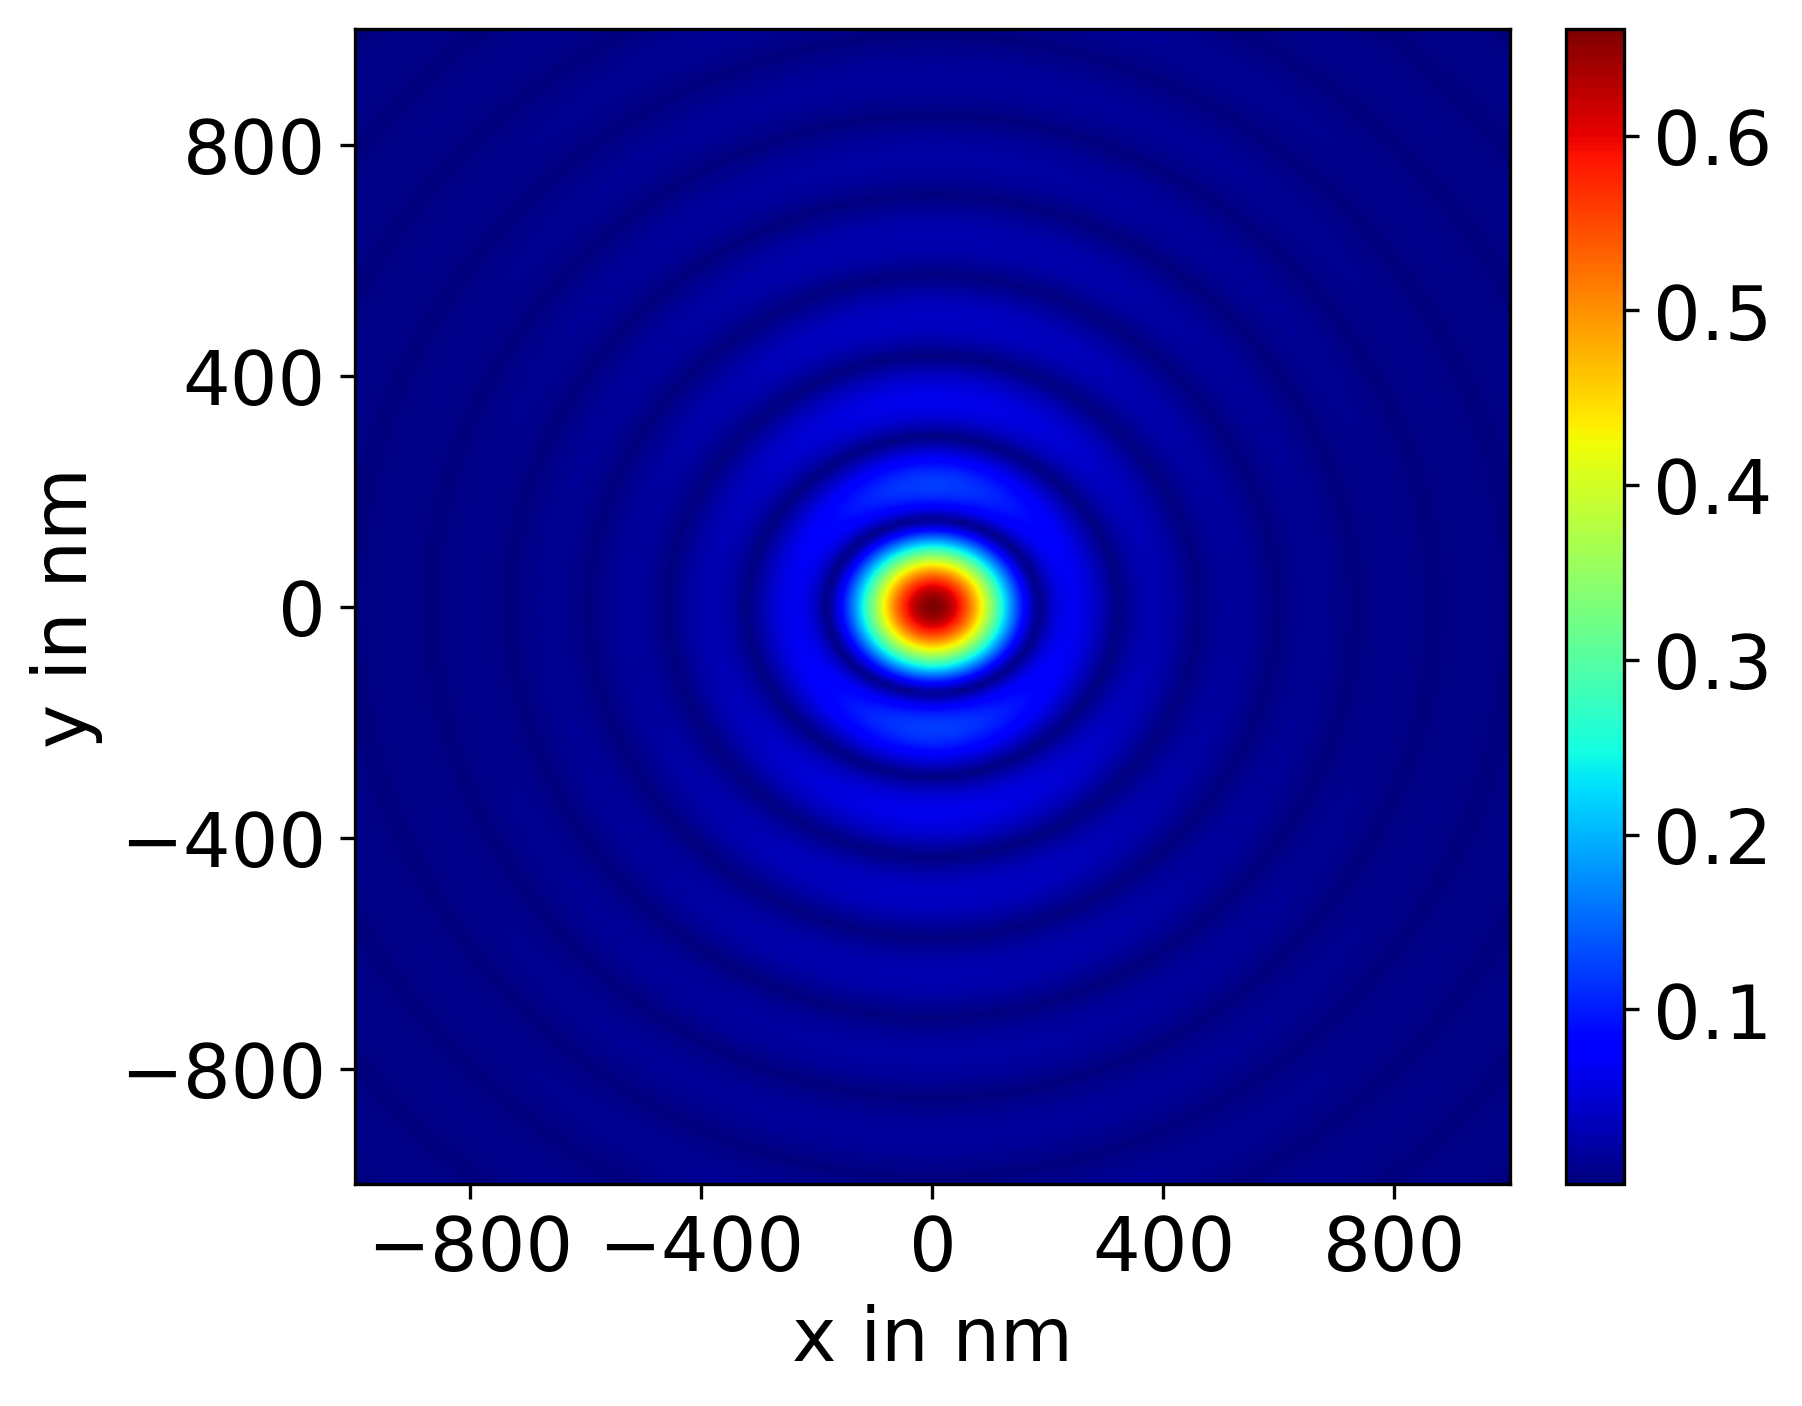

In [5]:
# plot Ex magnitude

#normalise field componentfactor=np.abs(Efield[:,:,0]).max()+np.abs(Efield[:,:,1]).max()+np.abs(Efield[:,:,2]).max()
#factor=1.0

fig, ax = plt.subplots(facecolor="white",figsize=(6,5), dpi=300)
im1 = ax.imshow(np.abs(Efield[:,:,0].T)/factor, origin="lower",extent=[startx*1E9,stopx*1E9,starty*1E9,stopy*1E9],cmap="jet")
im1.set_interpolation('bilinear')
cb2 = fig.colorbar(im1, ax=ax,fraction=0.046, pad=0.04)
cb2.ax.tick_params(labelsize=18)
plt.xlabel('x in nm',fontsize=18)
plt.ylabel('y in nm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([-800, -400, 0, 400, 800])
plt.yticks([-800, -400, 0, 400, 800])

#plt.savefig('Ex_405nm_Na1-4_full_xpol_lateral_HHRes.png', format='png')

([<matplotlib.axis.YTick at 0x267a2ef7950>,
 [Text(0, -800, '−800'),
  Text(0, -400, '−400'),
  Text(0, 0, '0'),
  Text(0, 400, '400'),
  Text(0, 800, '800')])

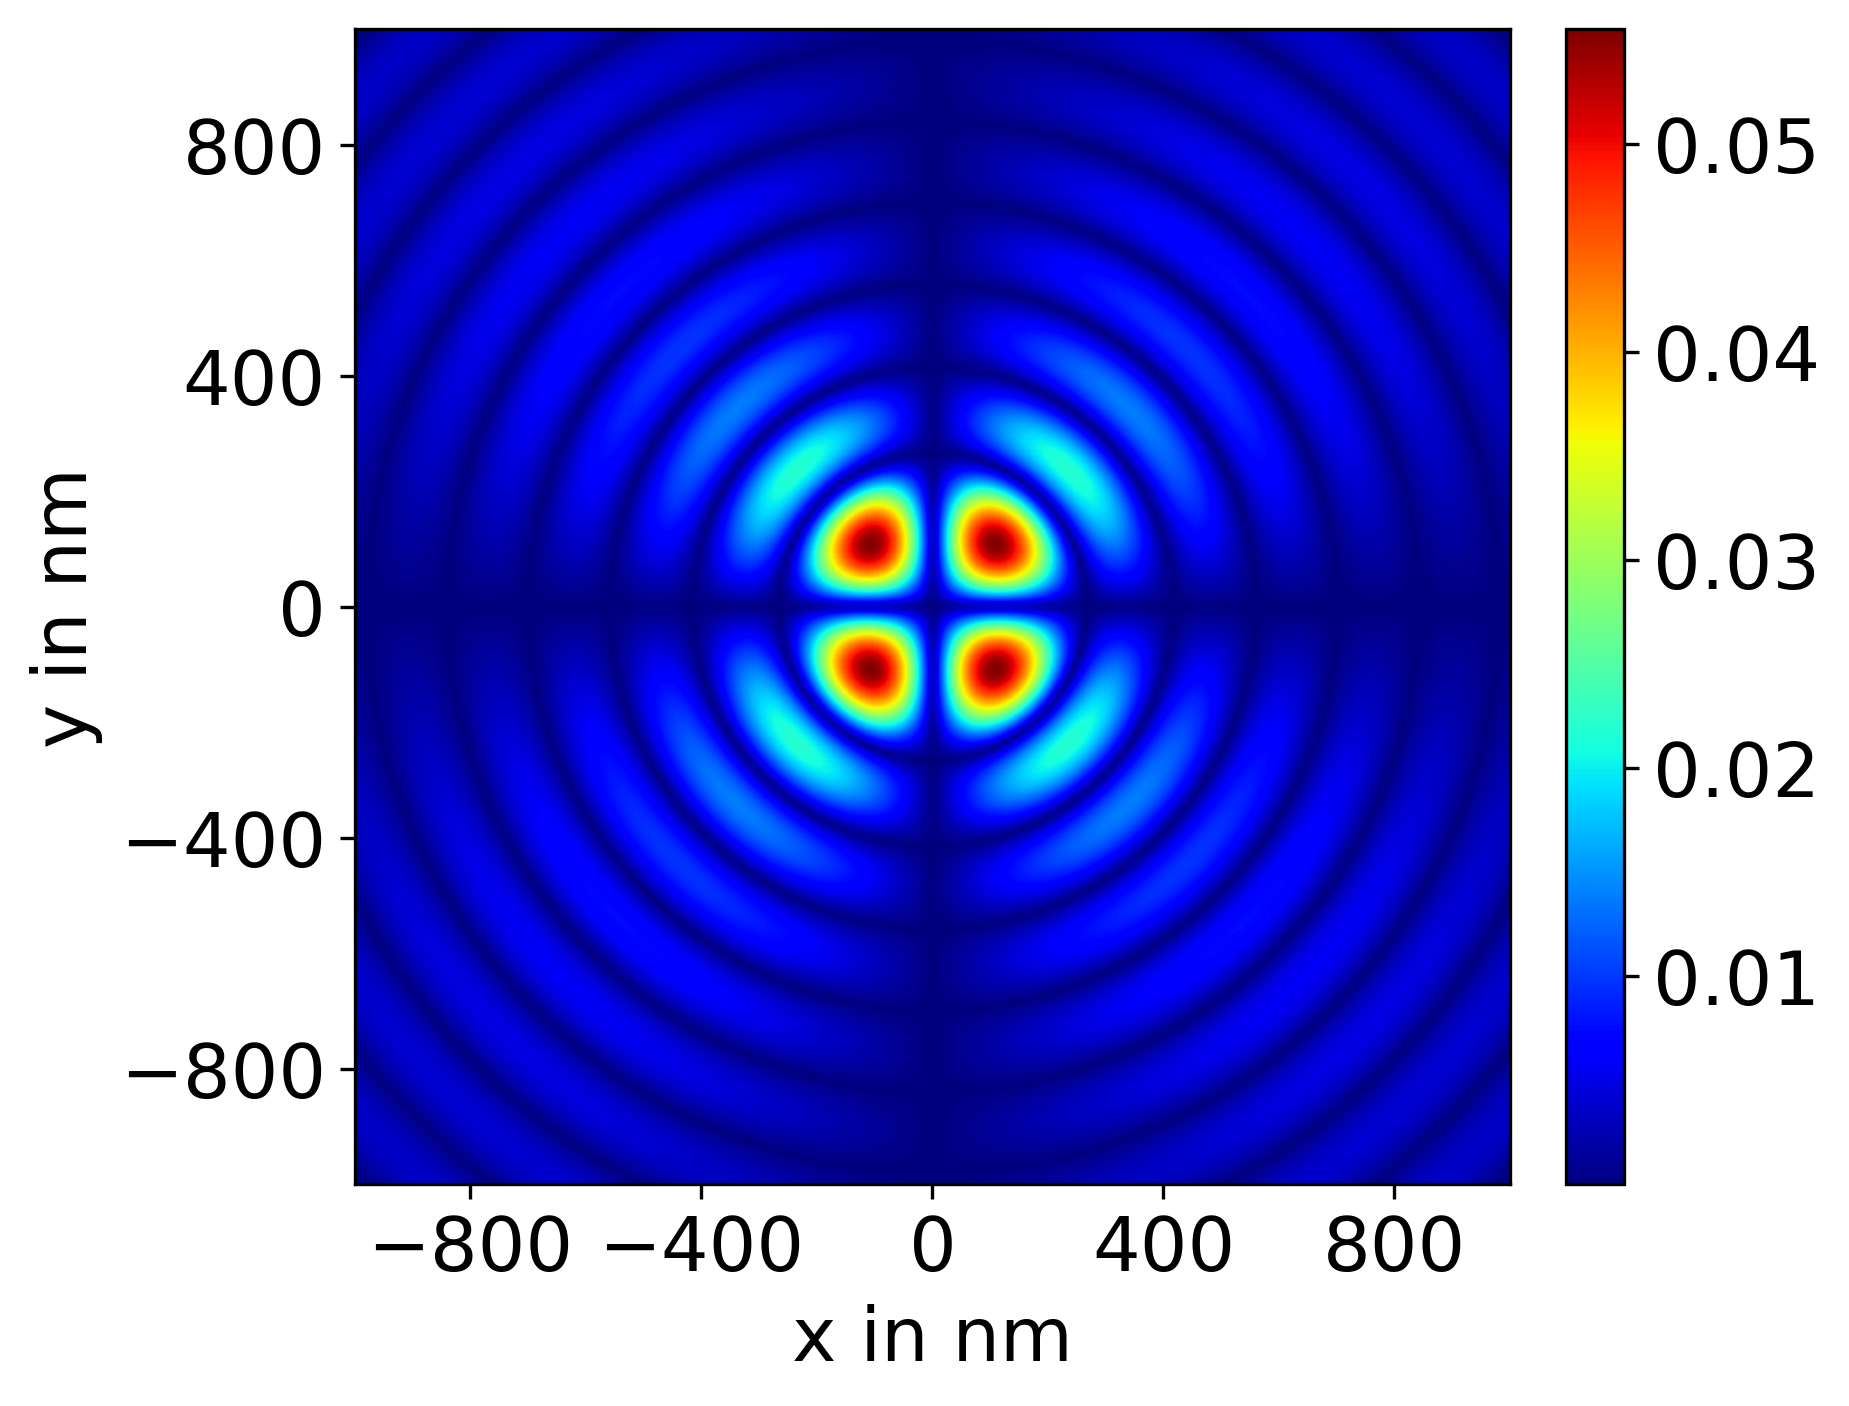

In [6]:
# plot Ey magnitude


fig, ax = plt.subplots(facecolor="white",figsize=(6,5), dpi=300)
im2 = ax.imshow(np.abs(Efield[:,:,1].T)/factor, origin="lower",extent=[startx*1E9,stopx*1E9,starty*1E9,stopy*1E9],cmap="jet")
im2.set_interpolation('bilinear')
cb2 = fig.colorbar(im2, ax=ax,fraction=0.046, pad=0.04)
cb2.ax.tick_params(labelsize=18)
plt.xlabel('x in nm',fontsize=18)
plt.ylabel('y in nm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([-800, -400, 0, 400, 800])
plt.yticks([-800, -400, 0, 400, 800])

#plt.savefig('Ey_405nm_Na1-4_full_xpol_lateral_HHRes.png', format='png')

([<matplotlib.axis.YTick at 0x267a38ce180>,
 [Text(0, -800, '−800'),
  Text(0, -400, '−400'),
  Text(0, 0, '0'),
  Text(0, 400, '400'),
  Text(0, 800, '800')])

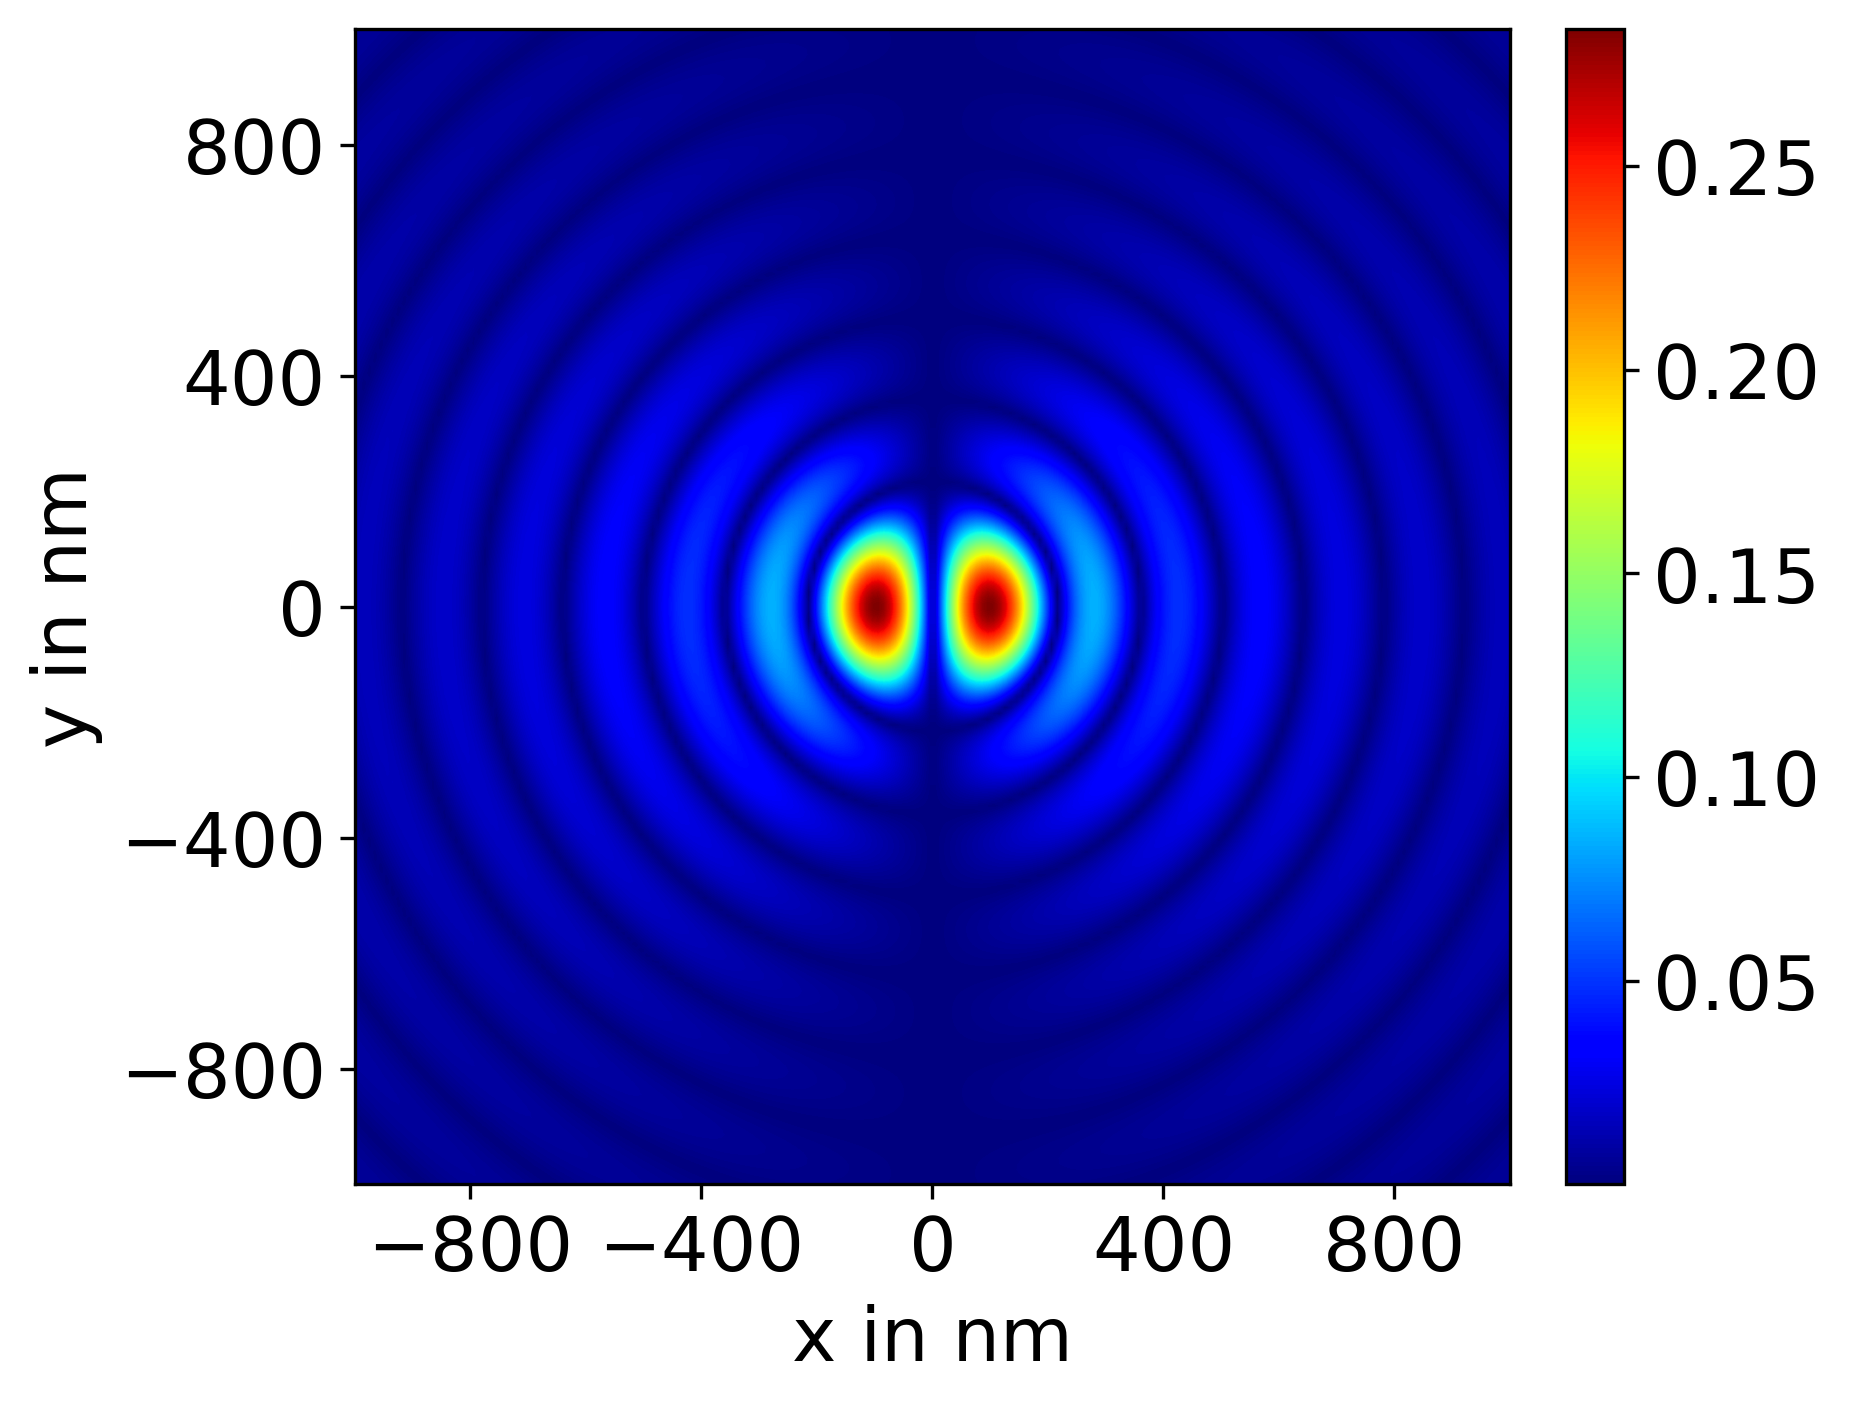

In [7]:
# plot Ez magnitude

fig, ax = plt.subplots(facecolor="white",figsize=(6,5), dpi=300)
im3 = ax.imshow(np.abs(Efield[:,:,2].T)/factor, origin="lower",extent=[startx*1E9,stopx*1E9,starty*1E9,stopy*1E9],cmap="jet")
im3.set_interpolation('bilinear')
cb2 = fig.colorbar(im3, ax=ax,fraction=0.046, pad=0.04)
cb2.ax.tick_params(labelsize=18)
plt.xlabel('x in nm',fontsize=18)
plt.ylabel('y in nm',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks([-800, -400, 0, 400, 800])
plt.yticks([-800, -400, 0, 400, 800])

#plt.savefig('Ez_405nm_Na1-4_full_xpol_lateral_HHRes.png', format='png')

x diameter in m (FWHM): [1.9101356e-07]
y diameter in m (FWHM): [1.31676895e-07]


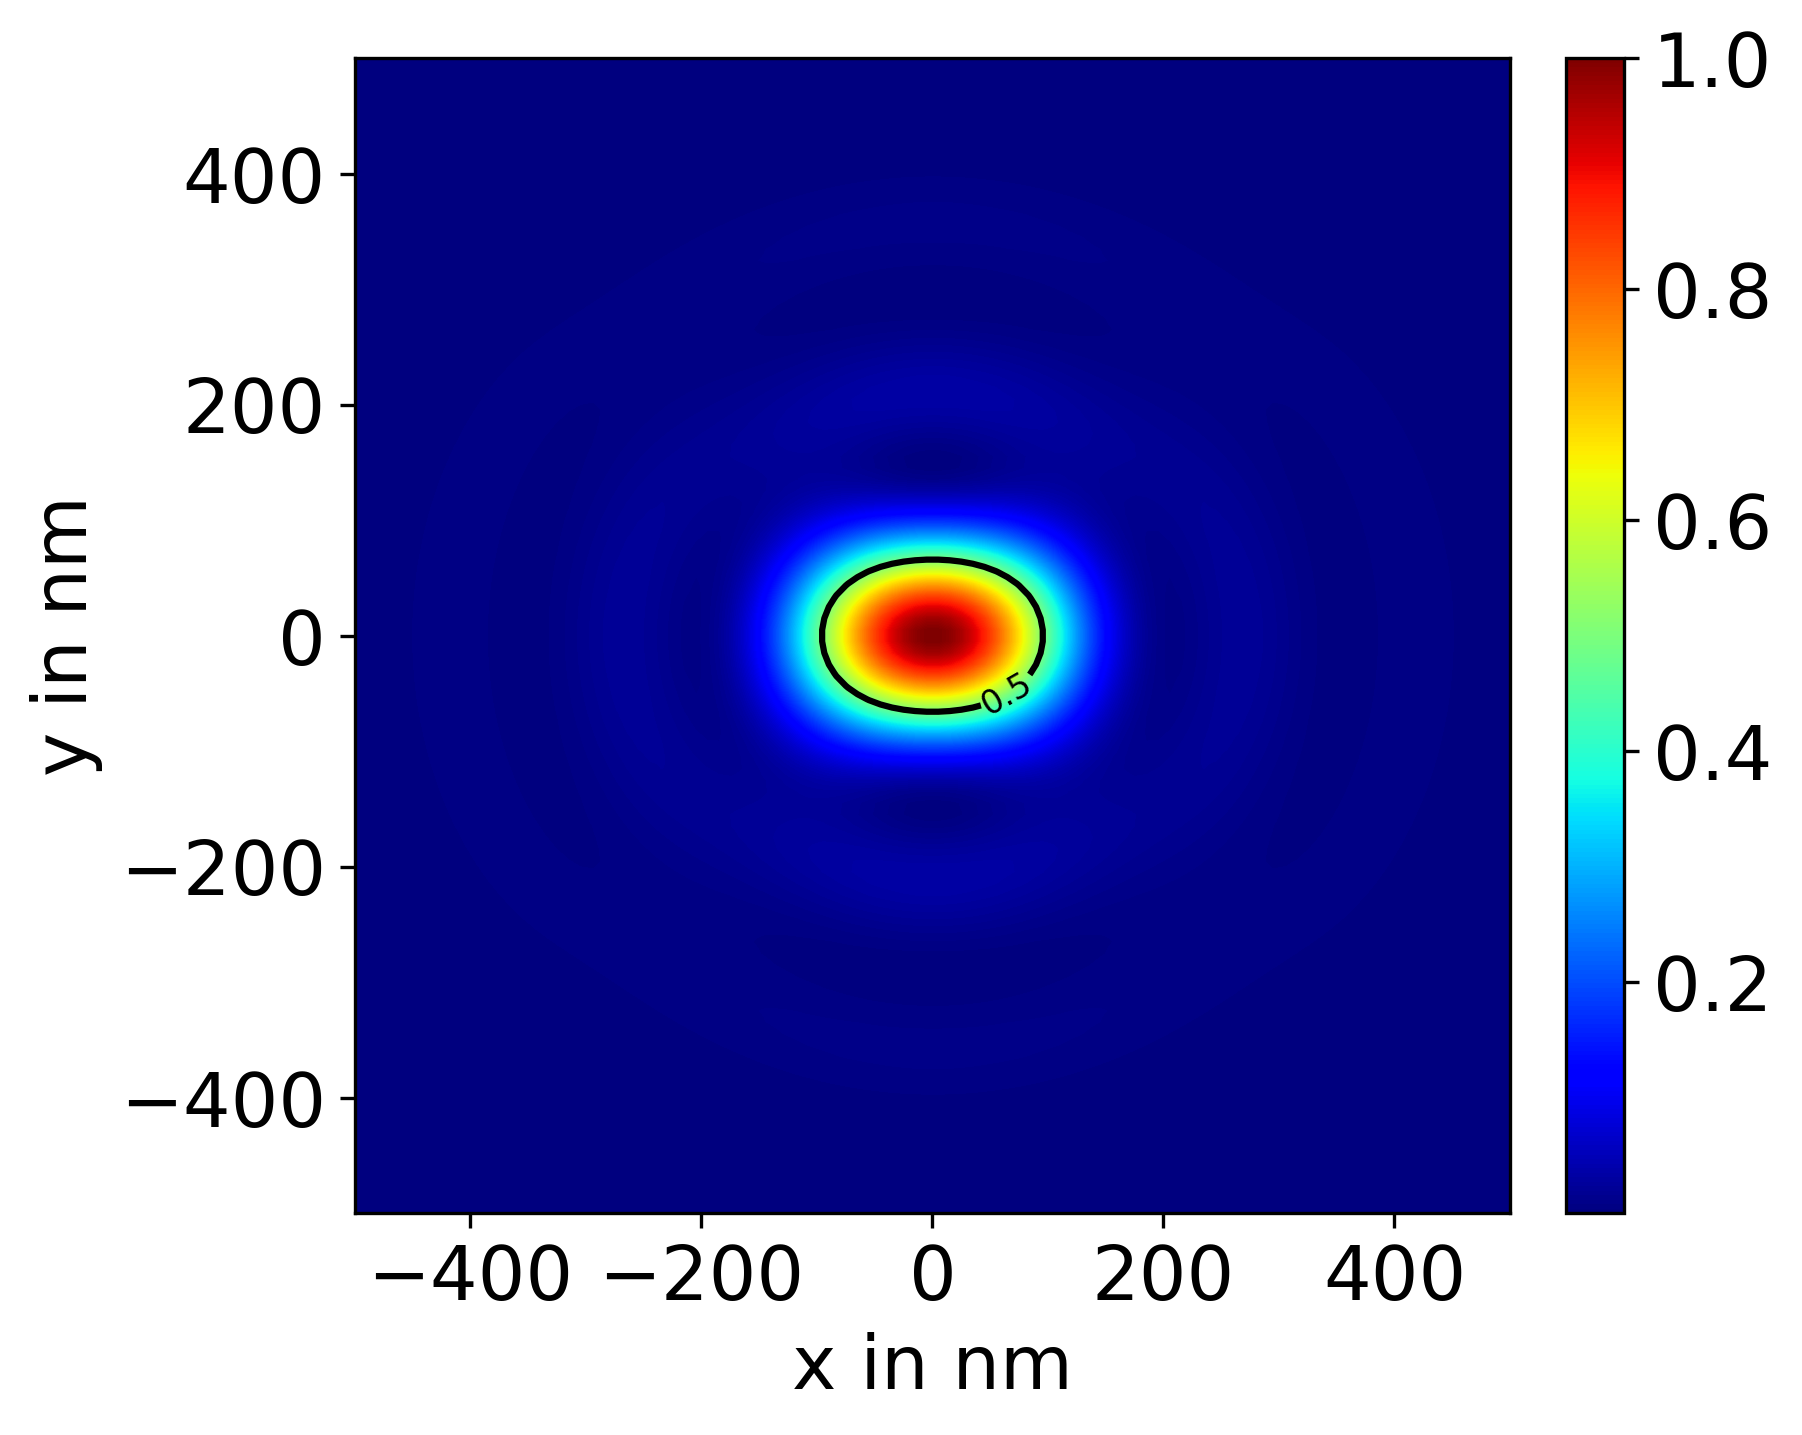

In [8]:
# plot normalized Intensity / PSF
fig, ax = plt.subplots(facecolor="white",figsize=(6,5), dpi=300)

Intensity=np.real(Efield[:,:,0]*np.conj(Efield[:,:,0])+Efield[:,:,1]*np.conj(Efield[:,:,1])+Efield[:,:,2]*np.conj(Efield[:,:,2]))
factor=Intensity[:,:].max()    
Intensity[:,:]=Intensity[:,:]/factor             
    
im4 = ax.imshow(Intensity[50:150,50:150].T,origin="lower",extent=[startx*1E9/2,stopx*1E9/2,starty*1E9/2,stopy*1E9/2],cmap="jet")
im4.set_interpolation('bilinear')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
cb2 = fig.colorbar(im4, ax=ax,fraction=0.046, pad=0.04)
cb2.ax.tick_params(labelsize=18)

plt.xlabel('x in nm', fontsize=18)
plt.ylabel('y in nm' , fontsize=18)

contours = plt.contour(Intensity[50:150,50:150].T, levels = [0.5], colors='black',origin="lower",extent=[startx*1E9/2,stopx*1E9/2,starty*1E9/2,stopy*1E9/2])
ax.clabel(contours, inline=True, fontsize=8)

from scipy.signal import find_peaks, peak_widths
peaks, _ = find_peaks(Intensity[:,100],width=15)
results_half = peak_widths(Intensity[:,100], peaks, rel_height=0.5)
print("x diameter in m (FWHM):",results_half[0]*(stopx-startx)/spacex)
peaks, _ = find_peaks(Intensity[100,:],width=10)
results_half = peak_widths(Intensity[100,:], peaks, rel_height=0.5)
print("y diameter in m (FWHM):",results_half[0]*(stopy-starty)/spacey)

#plt.savefig("I_405xpol_NA1-4__full_lateral.png")